# Online Gaming Behavior

### Por que é adequada à regressão:

- Possui múltiplas variáveis explicativas (demografia, hábito de jogo, engajamento).
- Possui alvos contínuos viáveis: AvgSessionDurationMinutes (10–179 min) e/ou PlayTimeHours (0.024–23.96 h).
- Aplicabilidade prática: previsão de duração média de sessão ajuda a dimensionar servidores, matchmaking e personalização.


## Pré-processamento

Carregamento dataset

In [91]:
import pandas as pd
import numpy as np

df = pd.read_csv("../data/online_gaming_insights.csv")


Inspeção inicial

In [92]:
df.head()
df.info()
df.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40034 entries, 0 to 40033
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PlayerID                   40034 non-null  int64  
 1   Age                        40034 non-null  int64  
 2   Gender                     40034 non-null  object 
 3   Location                   40034 non-null  object 
 4   GameGenre                  40034 non-null  object 
 5   PlayTimeHours              40034 non-null  float64
 6   InGamePurchases            40034 non-null  int64  
 7   GameDifficulty             40034 non-null  object 
 8   SessionsPerWeek            40034 non-null  int64  
 9   AvgSessionDurationMinutes  40034 non-null  int64  
 10  PlayerLevel                40034 non-null  int64  
 11  AchievementsUnlocked       40034 non-null  int64  
 12  EngagementLevel            40034 non-null  object 
dtypes: float64(1), int64(7), object(5)
memory usag

,PlayerID,Age,Gender,Location,GameGenre,PlayTimeHours,InGamePurchases,GameDifficulty,SessionsPerWeek,AvgSessionDurationMinutes,PlayerLevel,AchievementsUnlocked,EngagementLevel
count,40034.000000,40034.000000,40034,40034,40034,40034.000000,40034.000000,40034,40034.000000,40034.000000,40034.000000,40034.000000,40034
unique,NaN,NaN,2,4,5,NaN,NaN,3,NaN,NaN,NaN,NaN,3
top,NaN,NaN,Male,USA,Sports,NaN,NaN,Easy,NaN,NaN,NaN,NaN,Medium
freq,NaN,NaN,23959,16000,8048,NaN,NaN,20015,NaN,NaN,NaN,NaN,19374
mean,29016.500000,31.992531,NaN,NaN,NaN,12.024365,0.200854,NaN,9.471774,94.792252,49.655568,24.526477,NaN
std,11556.964675,10.043227,NaN,NaN,NaN,6.914638,0.400644,NaN,5.763667,49.011375,28.588379,14.430726,NaN
min,9000.000000,15.000000,NaN,NaN,NaN,0.000115,0.000000,NaN,0.000000,10.000000,1.000000,0.000000,NaN
25%,19008.250000,23.000000,NaN,NaN,NaN,6.067501,0.000000,NaN,4.000000,52.000000,25.000000,12.000000,NaN
50%,29016.500000,32.000000,NaN,NaN,NaN,12.008002,0.000000,NaN,9.000000,95.000000,49.000000,25.000000,NaN
75%,39024.750000,41.000000,NaN,NaN,NaN,17.963831,0.000000,NaN,14.000000,137.000000,74.000000,37.000000,NaN


Tipagem de colunas

In [93]:
num_cols = [
    "Age","PlayTimeHours","SessionsPerWeek","AvgSessionDurationMinutes",
    "PlayerLevel","AchievementsUnlocked"
]
cat_cols = [
    "Gender","Location","GameGenre","GameDifficulty","EngagementLevel",
    "InGamePurchases"
]

Define o alvo (tempo médio de sessão em minutos)

In [94]:
target = "AvgSessionDurationMinutes"

Valores faltantes

In [95]:
df.isna().sum()

PlayerID                     0
Age                          0
Gender                       0
Location                     0
GameGenre                    0
PlayTimeHours                0
InGamePurchases              0
GameDifficulty               0
SessionsPerWeek              0
AvgSessionDurationMinutes    0
PlayerLevel                  0
AchievementsUnlocked         0
EngagementLevel              0
dtype: int64

Valores duplicados

In [96]:
df.duplicated().sum()

0

Separa X, y e remove colunas que não são úteis

In [97]:
drop_cols = ["PlayerID", "GameGenre", "GameDifficulty", "InGamePurchases", "Location", "Gender", target]
X = df.drop(columns=drop_cols)
y = df[target]

Tratamento de colunas com ColumnTransformer e pipelines

In [98]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

feature_cols = X.columns
num_cols_X = [c for c in num_cols if c != target and c in feature_cols]
cat_cols_X = [c for c in cat_cols if c in feature_cols]

num_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols_X),
        ("cat", cat_pipe, cat_cols_X)
    ]
)

## Análise exploratória

In [99]:
df.describe(include='all')

,PlayerID,Age,Gender,Location,GameGenre,PlayTimeHours,InGamePurchases,GameDifficulty,SessionsPerWeek,AvgSessionDurationMinutes,PlayerLevel,AchievementsUnlocked,EngagementLevel
count,40034.000000,40034.000000,40034,40034,40034,40034.000000,40034.000000,40034,40034.000000,40034.000000,40034.000000,40034.000000,40034
unique,NaN,NaN,2,4,5,NaN,NaN,3,NaN,NaN,NaN,NaN,3
top,NaN,NaN,Male,USA,Sports,NaN,NaN,Easy,NaN,NaN,NaN,NaN,Medium
freq,NaN,NaN,23959,16000,8048,NaN,NaN,20015,NaN,NaN,NaN,NaN,19374
mean,29016.500000,31.992531,NaN,NaN,NaN,12.024365,0.200854,NaN,9.471774,94.792252,49.655568,24.526477,NaN
std,11556.964675,10.043227,NaN,NaN,NaN,6.914638,0.400644,NaN,5.763667,49.011375,28.588379,14.430726,NaN
min,9000.000000,15.000000,NaN,NaN,NaN,0.000115,0.000000,NaN,0.000000,10.000000,1.000000,0.000000,NaN
25%,19008.250000,23.000000,NaN,NaN,NaN,6.067501,0.000000,NaN,4.000000,52.000000,25.000000,12.000000,NaN
50%,29016.500000,32.000000,NaN,NaN,NaN,12.008002,0.000000,NaN,9.000000,95.000000,49.000000,25.000000,NaN
75%,39024.750000,41.000000,NaN,NaN,NaN,17.963831,0.000000,NaN,14.000000,137.000000,74.000000,37.000000,NaN


In [100]:
pd_types = pd.api.types

for col in df.columns:
  if(col == target):
    continue;

  if pd_types.is_numeric_dtype(df[col]) and not pd_types.is_bool_dtype(df[col]):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    print(f"IQR {IQR}")

    lower_bound = Q1 - 1 * IQR
    upper_bound = Q3 + 1 * IQR

    print(f"lower bound {lower_bound}")
    print(f"upper bound {upper_bound}")

    outliers_iqr = df[(df[col] < lower_bound) | (df[col] > upper_bound)]

    print(f"Number of outliers in {col} using IQR: {len(outliers_iqr)}", "\n")
    if len(outliers_iqr) > 0:
      display(outliers_iqr)

IQR 20016.5
lower bound -1008.25
upper bound 59041.25
Number of outliers in PlayerID using IQR: 0 

IQR 18.0
lower bound 5.0
upper bound 59.0
Number of outliers in Age using IQR: 0 

IQR 11.89633063054563
lower bound -5.828830122795504
upper bound 29.860161768841387
Number of outliers in PlayTimeHours using IQR: 0 

IQR 0.0
lower bound 0.0
upper bound 0.0
Number of outliers in InGamePurchases using IQR: 8041 



,PlayerID,Age,Gender,Location,GameGenre,PlayTimeHours,InGamePurchases,GameDifficulty,SessionsPerWeek,AvgSessionDurationMinutes,PlayerLevel,AchievementsUnlocked,EngagementLevel
3,9003,35,Male,USA,Action,5.265351,1,Easy,9,85,57,47,Medium
11,9011,36,Female,Asia,Simulation,5.535981,1,Easy,16,124,62,31,High
12,9012,16,Male,USA,Sports,18.776234,1,Easy,9,18,52,32,High
31,9031,39,Male,USA,Sports,3.374946,1,Easy,5,70,50,11,Medium
40,9040,49,Female,Europe,Strategy,13.714087,1,Medium,15,43,93,29,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...
40020,49020,16,Male,USA,RPG,10.687862,1,Easy,16,118,18,16,High
40021,49021,43,Male,Asia,Action,6.146619,1,Medium,7,107,86,26,Medium
40026,49026,33,Male,Other,Sports,19.825140,1,Easy,12,166,44,11,High
40031,49031,15,Female,USA,RPG,0.240057,1,Easy,10,176,29,1,High


IQR 10.0
lower bound -6.0
upper bound 24.0
Number of outliers in SessionsPerWeek using IQR: 0 

IQR 49.0
lower bound -24.0
upper bound 123.0
Number of outliers in PlayerLevel using IQR: 0 

IQR 25.0
lower bound -13.0
upper bound 62.0
Number of outliers in AchievementsUnlocked using IQR: 0 



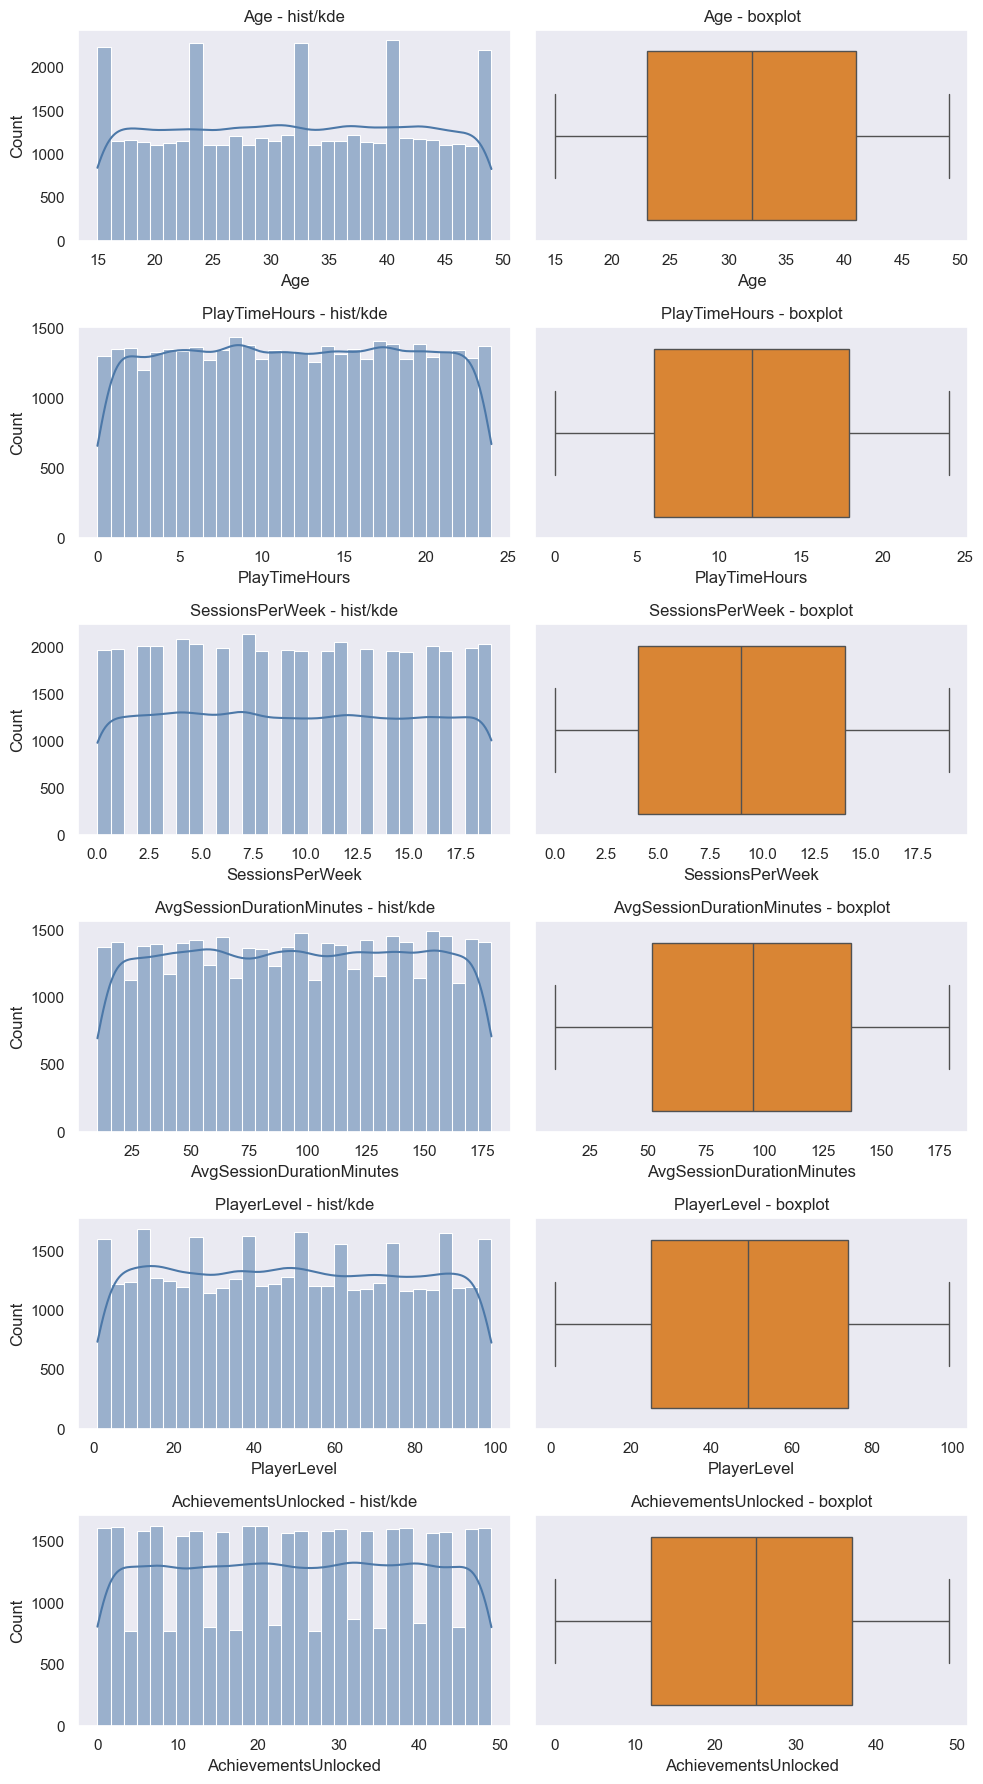

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="dark", context="notebook")

num_cols_plot = num_cols.copy()
fig, axes = plt.subplots(len(num_cols_plot), 2, figsize=(10, 3*len(num_cols_plot)))
for i, c in enumerate(num_cols_plot):
    sns.histplot(df[c], bins=30, kde=True, ax=axes[i, 0], color="#4C78A8")
    axes[i, 0].set_title(f"{c} - hist/kde")
    sns.boxplot(x=df[c], ax=axes[i, 1], orient="h", color="#F58518")
    axes[i, 1].set_title(f"{c} - boxplot")
plt.tight_layout()
plt.show()


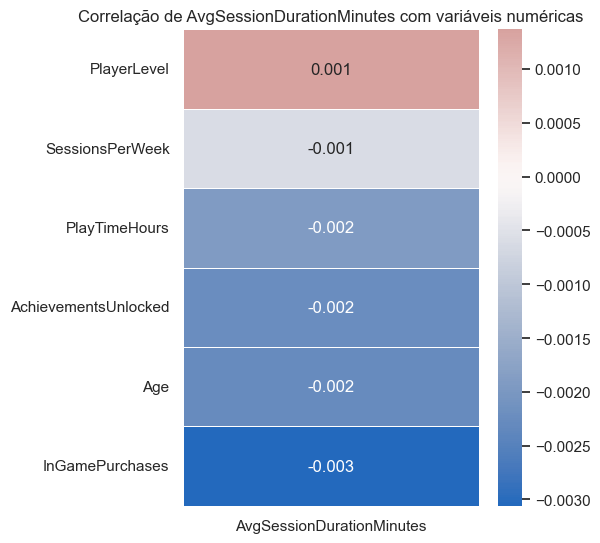

In [102]:
numeric_df = df.select_dtypes(include=np.number).drop(columns=["PlayerID"], errors="ignore")
target_corr = numeric_df.corrwith(df[target]).drop(labels=[target]).sort_values(ascending=False)

plt.figure(figsize=(6, 0.6 * len(target_corr) + 2))
sns.heatmap(target_corr.to_frame(name=target), annot=True, cmap="vlag", center=0,
            linewidths=0.5, fmt=".3f")
plt.title(f"Correlação de {target} com variáveis numéricas")
plt.tight_layout()
plt.show()


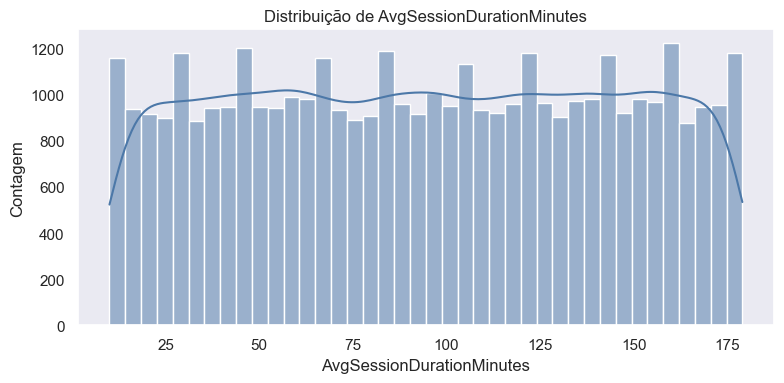

count    40034.000000
mean        94.792252
std         49.011375
min         10.000000
25%         52.000000
50%         95.000000
75%        137.000000
90%        162.000000
95%        171.000000
max        179.000000
Name: AvgSessionDurationMinutes, dtype: float64

In [103]:
plt.figure(figsize=(8, 4))
sns.histplot(df[target], bins=40, kde=True, color="#4C78A8")
plt.title(f"Distribuição de {target}")
plt.xlabel(target)
plt.ylabel("Contagem")
plt.tight_layout()
plt.show()

stats = df[target].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95])
display(stats)


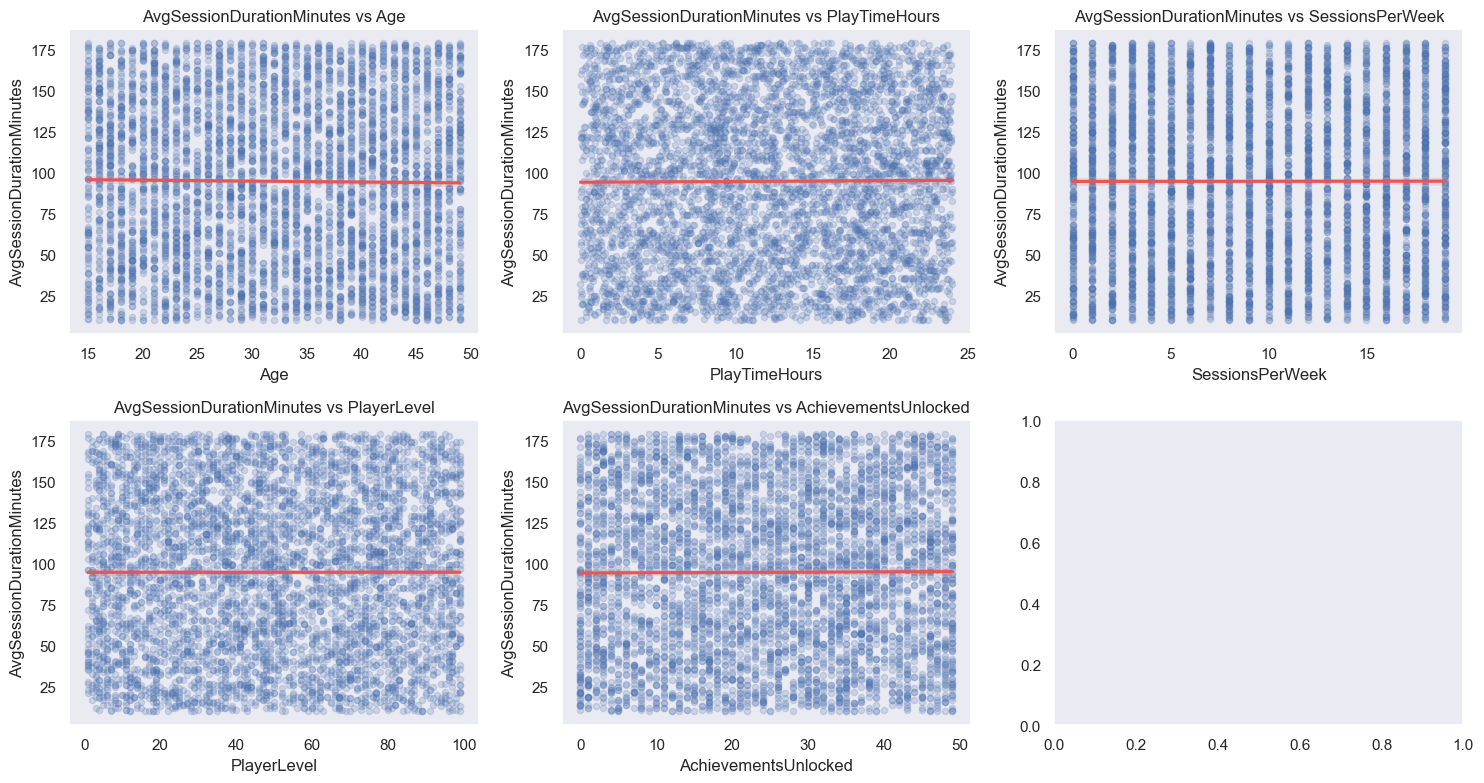

In [104]:
num_relations = ["Age", "PlayTimeHours", "SessionsPerWeek", "PlayerLevel", "AchievementsUnlocked"]
sample_df = df[num_relations + [target]].sample(n=5000, random_state=42)

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
for ax, feature in zip(axes.flatten(), num_relations):
    sns.regplot(
        data=sample_df,
        x=feature,
        y=target,
        scatter_kws={"alpha": 0.2, "s": 20},
        line_kws={"color": "#E45756"},
        ax=ax
    )
    ax.set_title(f"{target} vs {feature}")
plt.tight_layout()
plt.show()


C:\Users\guilh\AppData\Local\Temp\ipykernel_14264\3075532018.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(data=plot_df, x=cat_col, y=target, order=selected,


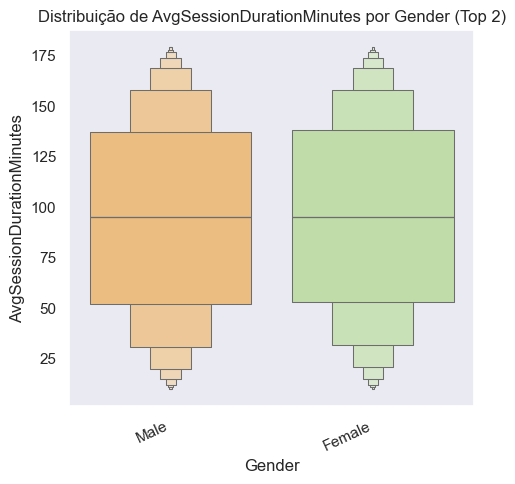

,count,mean,median,std
Gender,,,,
Male,23959,94.664802,95.0,49.103080
Female,16075,94.982208,95.0,48.875281


C:\Users\guilh\AppData\Local\Temp\ipykernel_14264\3075532018.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=stats.index, y=stats["mean"], palette="Spectral")


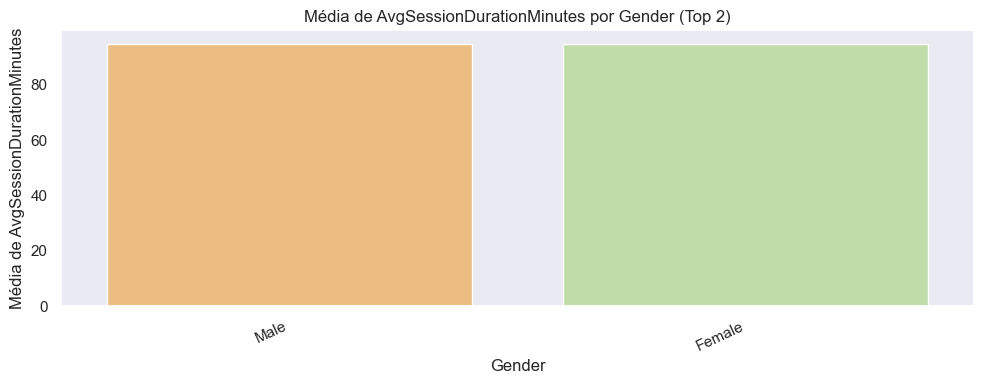

C:\Users\guilh\AppData\Local\Temp\ipykernel_14264\3075532018.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(data=plot_df, x=cat_col, y=target, order=selected,


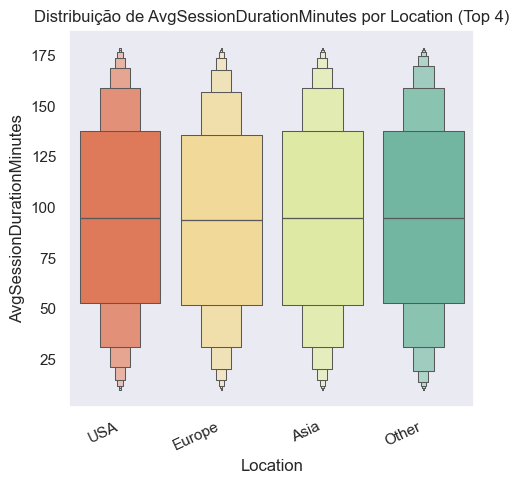

,count,mean,median,std
Location,,,,
USA,16000,95.189813,95.0,49.063158
Europe,12004,94.183106,94.0,48.587217
Asia,8095,94.836072,95.0,49.324001
Other,3935,94.943837,95.0,49.442357


C:\Users\guilh\AppData\Local\Temp\ipykernel_14264\3075532018.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=stats.index, y=stats["mean"], palette="Spectral")


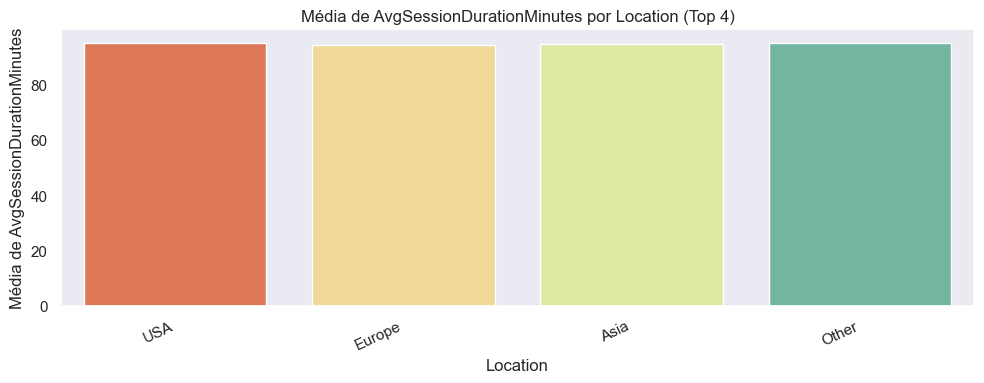

C:\Users\guilh\AppData\Local\Temp\ipykernel_14264\3075532018.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(data=plot_df, x=cat_col, y=target, order=selected,


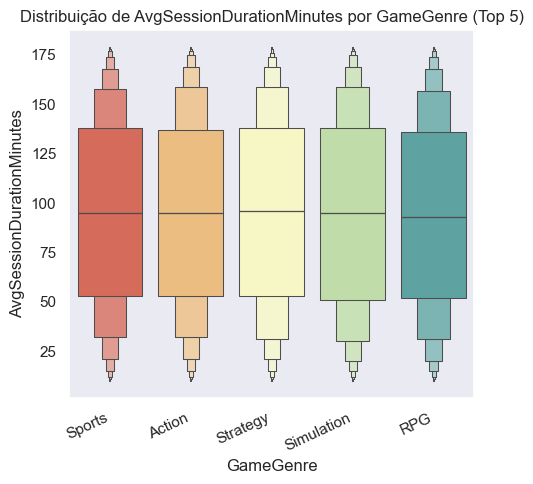

,count,mean,median,std
GameGenre,,,,
Sports,8048,95.046098,95.0,48.719084
Action,8039,94.782933,95.0,48.955658
Strategy,8012,95.641538,96.0,48.929982
Simulation,7983,94.739572,95.0,49.631877
RPG,7952,93.741952,93.0,48.810232


C:\Users\guilh\AppData\Local\Temp\ipykernel_14264\3075532018.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=stats.index, y=stats["mean"], palette="Spectral")


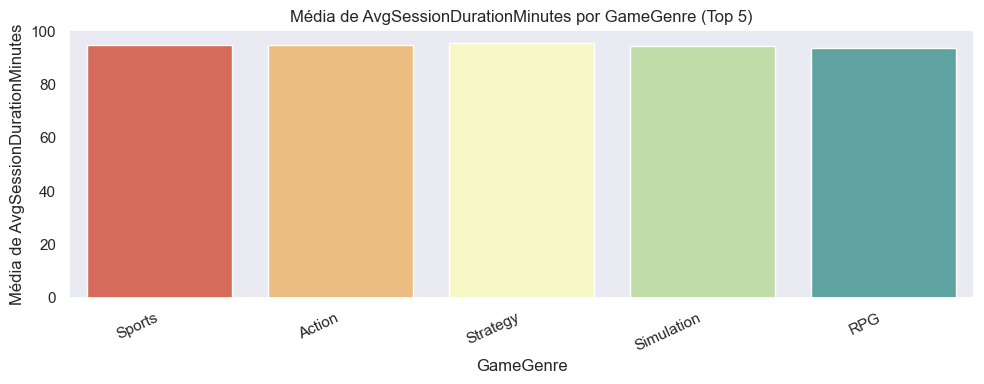

C:\Users\guilh\AppData\Local\Temp\ipykernel_14264\3075532018.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(data=plot_df, x=cat_col, y=target, order=selected,


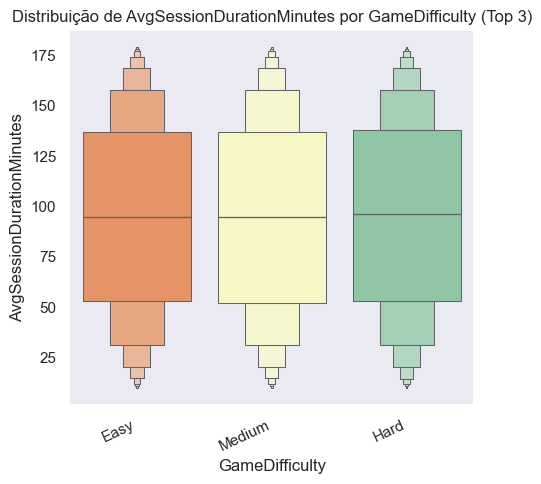

,count,mean,median,std
GameDifficulty,,,,
Easy,20015,94.780465,95.0,48.931407
Medium,12011,94.528599,95.0,49.097345
Hard,8008,95.217158,96.0,49.085189


C:\Users\guilh\AppData\Local\Temp\ipykernel_14264\3075532018.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=stats.index, y=stats["mean"], palette="Spectral")


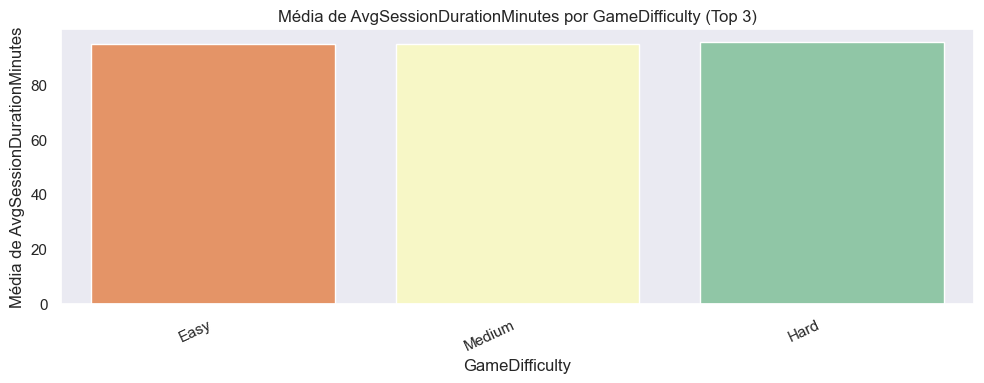

C:\Users\guilh\AppData\Local\Temp\ipykernel_14264\3075532018.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(data=plot_df, x=cat_col, y=target, order=selected,


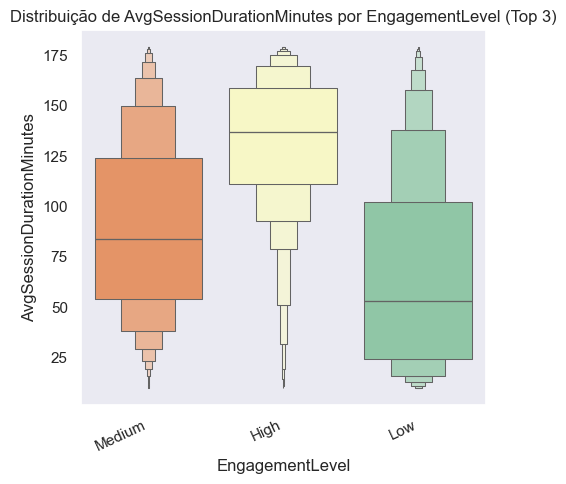

,count,mean,median,std
EngagementLevel,,,,
Medium,19374,89.856405,84.0,43.720468
High,10336,131.921827,137.0,34.072555
Low,10324,66.882119,53.0,48.588586


C:\Users\guilh\AppData\Local\Temp\ipykernel_14264\3075532018.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=stats.index, y=stats["mean"], palette="Spectral")


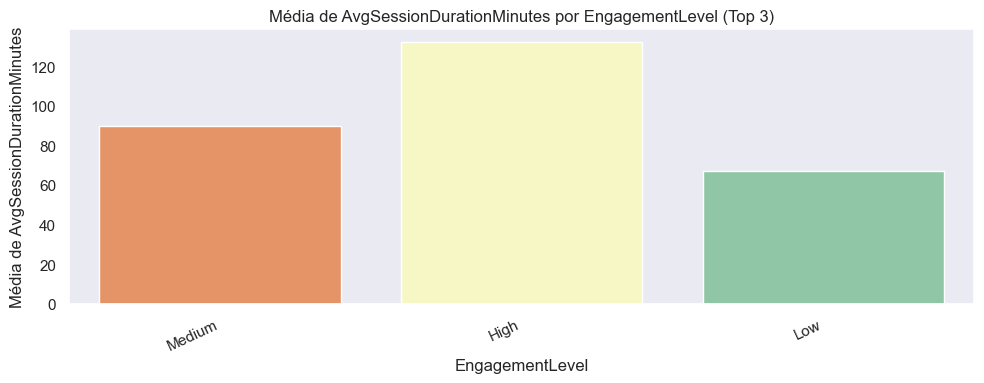

C:\Users\guilh\AppData\Local\Temp\ipykernel_14264\3075532018.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(data=plot_df, x=cat_col, y=target, order=selected,


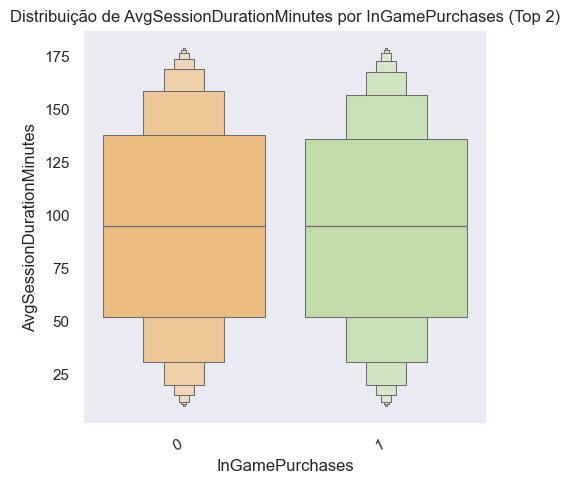

,count,mean,median,std
InGamePurchases,,,,
0,31993,94.867408,95.0,49.095010
1,8041,94.493222,95.0,48.679076


C:\Users\guilh\AppData\Local\Temp\ipykernel_14264\3075532018.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=stats.index, y=stats["mean"], palette="Spectral")


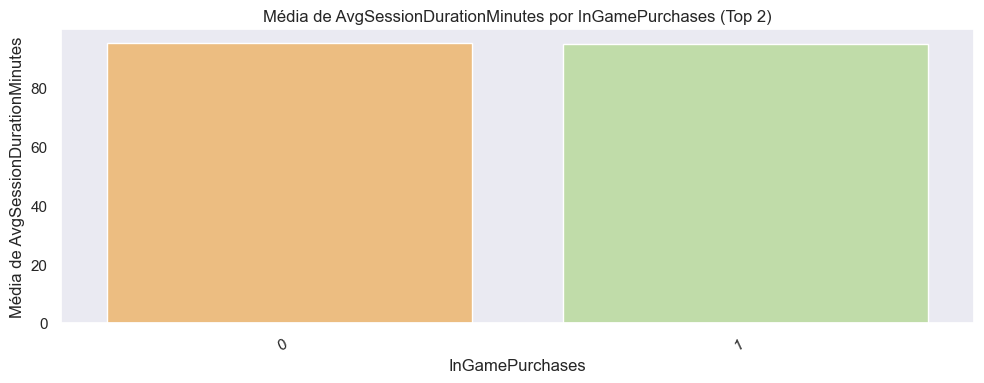

In [105]:
def plot_target_vs_categorical(cat_col, top_k=10):
    if cat_col not in df.columns:
        raise ValueError(f"Coluna {cat_col} não encontrada no dataframe.")

    counts = df[cat_col].value_counts()
    selected = counts.head(top_k).index
    plot_df = df[df[cat_col].isin(selected)].copy()

    plt.figure(figsize=(5, 5))
    sns.boxenplot(data=plot_df, x=cat_col, y=target, order=selected,
                  palette="Spectral", showfliers=False)
    plt.title(f"Distribuição de {target} por {cat_col} (Top {len(selected)})")
    plt.xlabel(cat_col)
    plt.ylabel(target)
    plt.xticks(rotation=25, ha="right")
    plt.tight_layout()
    plt.show()

    stats = (
        plot_df.groupby(cat_col)[target]
        .agg(["count", "mean", "median", "std"])
        .loc[selected]
    )

    display(stats)

    plt.figure(figsize=(10, 4))
    sns.barplot(x=stats.index, y=stats["mean"], palette="Spectral")
    plt.title(f"Média de {target} por {cat_col} (Top {len(selected)})")
    plt.xlabel(cat_col)
    plt.ylabel(f"Média de {target}")
    plt.xticks(rotation=25, ha="right")
    plt.tight_layout()
    plt.show()


for feature in ["Gender", "Location", "GameGenre", "GameDifficulty", "EngagementLevel", "InGamePurchases"]:
    plot_target_vs_categorical(feature, top_k=8)


In [106]:
df[target].value_counts().head(10)
df[target].quantile([.5,.9,.95,.99])

0.50     95.0
0.90    162.0
0.95    171.0
0.99    178.0
Name: AvgSessionDurationMinutes, dtype: float64

In [107]:
agg = df.groupby("PlayerID")[target].agg(["count","mean","std"])
agg["cv"] = agg["std"]/agg["mean"]
agg.sort_values("cv", ascending=False).head()


,count,mean,std,cv
PlayerID,,,,
9000,1,108.0,NaN,NaN
9001,1,144.0,NaN,NaN
9002,1,142.0,NaN,NaN
9003,1,85.0,NaN,NaN
9004,1,131.0,NaN,NaN


## Modelos de regressão

Funções utiliárias

In [108]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

def eval_regression(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name:25s} | MAE: {mae:.3f} | RMSE: {rmse:.3f} | R2: {r2:.3f}")
    return {"MAE":mae, "RMSE":rmse, "R2":r2}

def show_learning_curve(history):
    plt.plot(history.history['loss'], label='Treino')
    plt.plot(history.history['val_loss'], label='Validação')
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.legend()
    plt.show()

results = {}


Baseline (média)

In [109]:
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor

baseline = Pipeline([("prep", preprocess), ("model", DummyRegressor(strategy="mean"))])
baseline.fit(X_train, y_train)
pred = baseline.predict(X_test)
results["dummy_mean"] = eval_regression(y_test, pred, "Baseline (Mean)")


Baseline (Mean)           | MAE: 42.579 | RMSE: 49.176 | R2: -0.000


### KNN

In [110]:
from sklearn.neighbors import KNeighborsRegressor

knn = Pipeline([
    ("prep", preprocess),
    ("model", KNeighborsRegressor(n_neighbors=15, weights="distance"))
])
knn.fit(X_train, y_train)
pred = knn.predict(X_test)
results["knn"] = eval_regression(y_test, pred, "KNN Regressor")

KNN Regressor             | MAE: 29.839 | RMSE: 37.507 | R2: 0.418


### Árvore de Decisão

In [111]:
from sklearn.tree import DecisionTreeRegressor

dt = Pipeline([
    ("prep", preprocess),
    ("model", DecisionTreeRegressor(max_depth=6, random_state=42))
])
dt.fit(X_train, y_train)
pred = dt.predict(X_test)
results["decision_tree"] = eval_regression(y_test, pred, "Decision Tree Regressor")

Decision Tree Regressor   | MAE: 29.050 | RMSE: 36.465 | R2: 0.450


### Naive Bayes

In [112]:
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import KBinsDiscretizer

n_bins = 5
kbd = KBinsDiscretizer(n_bins=n_bins, encode="ordinal", strategy="quantile")
y_bin_train = kbd.fit_transform(y_train.to_numpy().reshape(-1,1)).astype(int).ravel()
bin_edges = kbd.bin_edges_[0]
bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])

gnb_clf = Pipeline([
    ("prep", preprocess),
    ("model", GaussianNB())
])
gnb_clf.fit(X_train, y_bin_train)

proba = gnb_clf.named_steps["model"].predict_proba(
    gnb_clf.named_steps["prep"].transform(X_test)
)
y_pred_gnb = (proba * bin_centers).sum(axis=1)

results["naive_bayes_as_reg"] = eval_regression(y_test, y_pred_gnb, "GaussianNB (bins→expectation)")

GaussianNB (bins→expectation) | MAE: 35.816 | RMSE: 46.308 | R2: 0.113


### Regressão linear

In [113]:
from sklearn.base import clone

preprocess_keras = clone(preprocess)
X_train_enc = preprocess_keras.fit_transform(X_train)
X_test_enc = preprocess_keras.transform(X_test)

if hasattr(X_train_enc, "toarray"):
    X_train_enc = X_train_enc.toarray()
    X_test_enc = X_test_enc.toarray()

X_train_enc = X_train_enc.astype("float32")
X_test_enc = X_test_enc.astype("float32")
y_train_keras = y_train.to_numpy().astype("float32")
y_test_keras = y_test.to_numpy().astype("float32")


Linear Regression (Keras) | MAE: 30.247 | RMSE: 39.680 | R2: 0.349


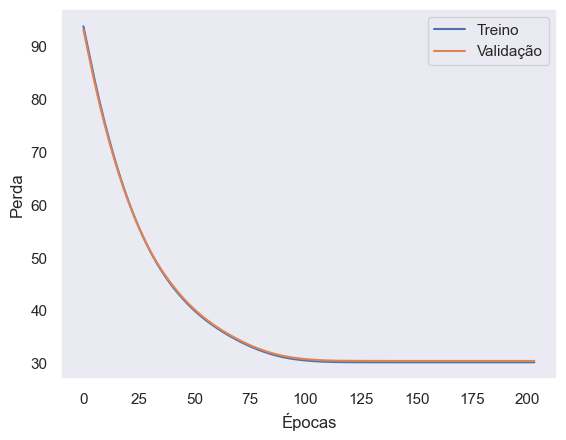

In [114]:
import tensorflow as tf

tf.keras.utils.set_random_seed(42)
tf.keras.backend.clear_session()

inputs = tf.keras.layers.Input(shape=(X_train_enc.shape[1],))
outputs = tf.keras.layers.Dense(1, activation="linear")(inputs)
model_lr = tf.keras.Model(inputs, outputs)

model_lr.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss="mae",
    metrics=["mae"],
)

early = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=20, restore_best_weights=True
)

history = model_lr.fit(
    X_train_enc, y_train_keras,
    epochs=300, batch_size=256,
    validation_split=0.2, verbose=0,
    callbacks=[early],
)

y_pred_lr = model_lr.predict(X_test_enc, verbose=0).ravel()
results["linear"] = eval_regression(y_test, y_pred_lr, "Linear Regression (Keras)")

show_learning_curve(history)

### Redes Neurais

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,689 (10.50 KB)

 Trainable params: 2,689 (10.50 KB)

 Non-trainable params: 0 (0.00 B)

Neural Network (Keras)    | MAE: 28.383 | RMSE: 36.875 | R2: 0.438


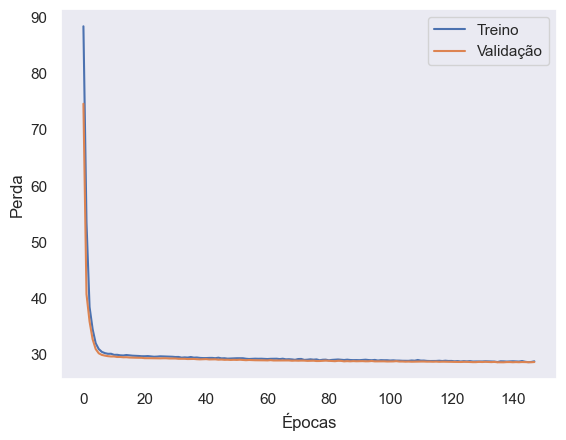

In [115]:
import tensorflow as tf

tf.keras.utils.set_random_seed(42)
tf.keras.backend.clear_session()

inputs = tf.keras.layers.Input(shape=(X_train_enc.shape[1],))
x = tf.keras.layers.Dense(64, activation="relu")(inputs)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(32, activation="relu")(x)
outputs = tf.keras.layers.Dense(1, activation="linear")(x)
model_mlp = tf.keras.Model(inputs, outputs)

model_mlp.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="mae",
    metrics=["mae"],
)

model_mlp.summary()

early = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)

history = model_mlp.fit(
    X_train_enc, y_train_keras,
    epochs=300, batch_size=256,
    validation_split=0.2, verbose=0,
    callbacks=[early],
)

y_pred_mlp = model_mlp.predict(X_test_enc, verbose=0).ravel()
results["neural"] = eval_regression(y_test, y_pred_mlp, "Neural Network (Keras)")

show_learning_curve(history)

### Análise de resultados

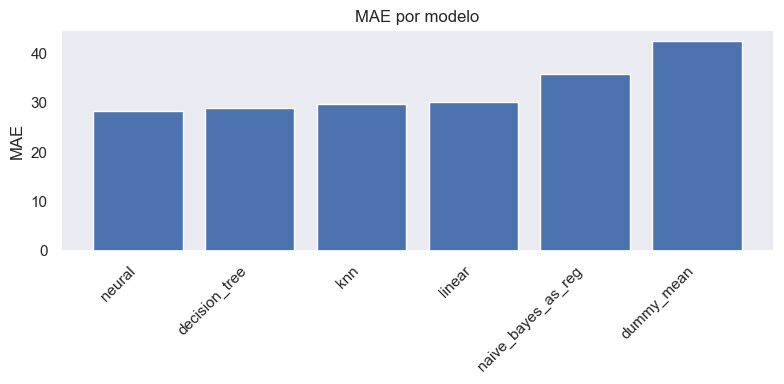

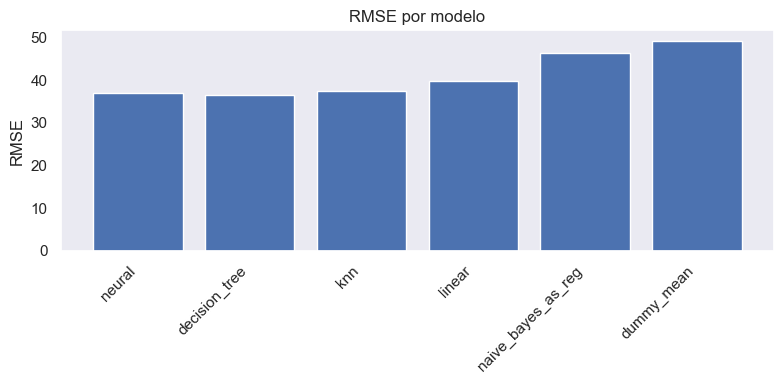

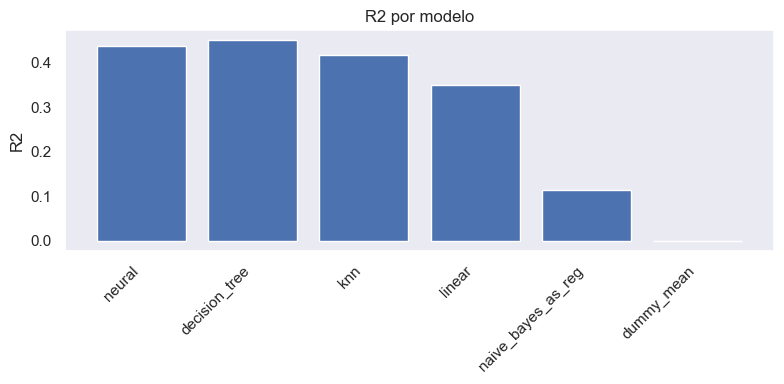

,MAE,RMSE,R2
neural,28.383327,36.874913,0.437707
decision_tree,29.050254,36.465333,0.450128
knn,29.838931,37.507006,0.418264
linear,30.246638,39.680167,0.348900
naive_bayes_as_reg,35.815563,46.307621,0.113241
dummy_mean,42.579324,49.175975,-0.000016


In [116]:
import pandas as pd
import matplotlib.pyplot as plt

results_df = pd.DataFrame(results).T
results_df = results_df.sort_values("MAE")

plt.figure(figsize=(8, 4))
plt.bar(results_df.index, results_df["MAE"])
plt.xticks(rotation=45, ha='right')
plt.ylabel("MAE")
plt.title("MAE por modelo")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.bar(results_df.index, results_df["RMSE"])
plt.xticks(rotation=45, ha='right')
plt.ylabel("RMSE")
plt.title("RMSE por modelo")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.bar(results_df.index, results_df["R2"])
plt.xticks(rotation=45, ha='right')
plt.ylabel("R2")
plt.title("R2 por modelo")
plt.tight_layout()
plt.show()

display(results_df)




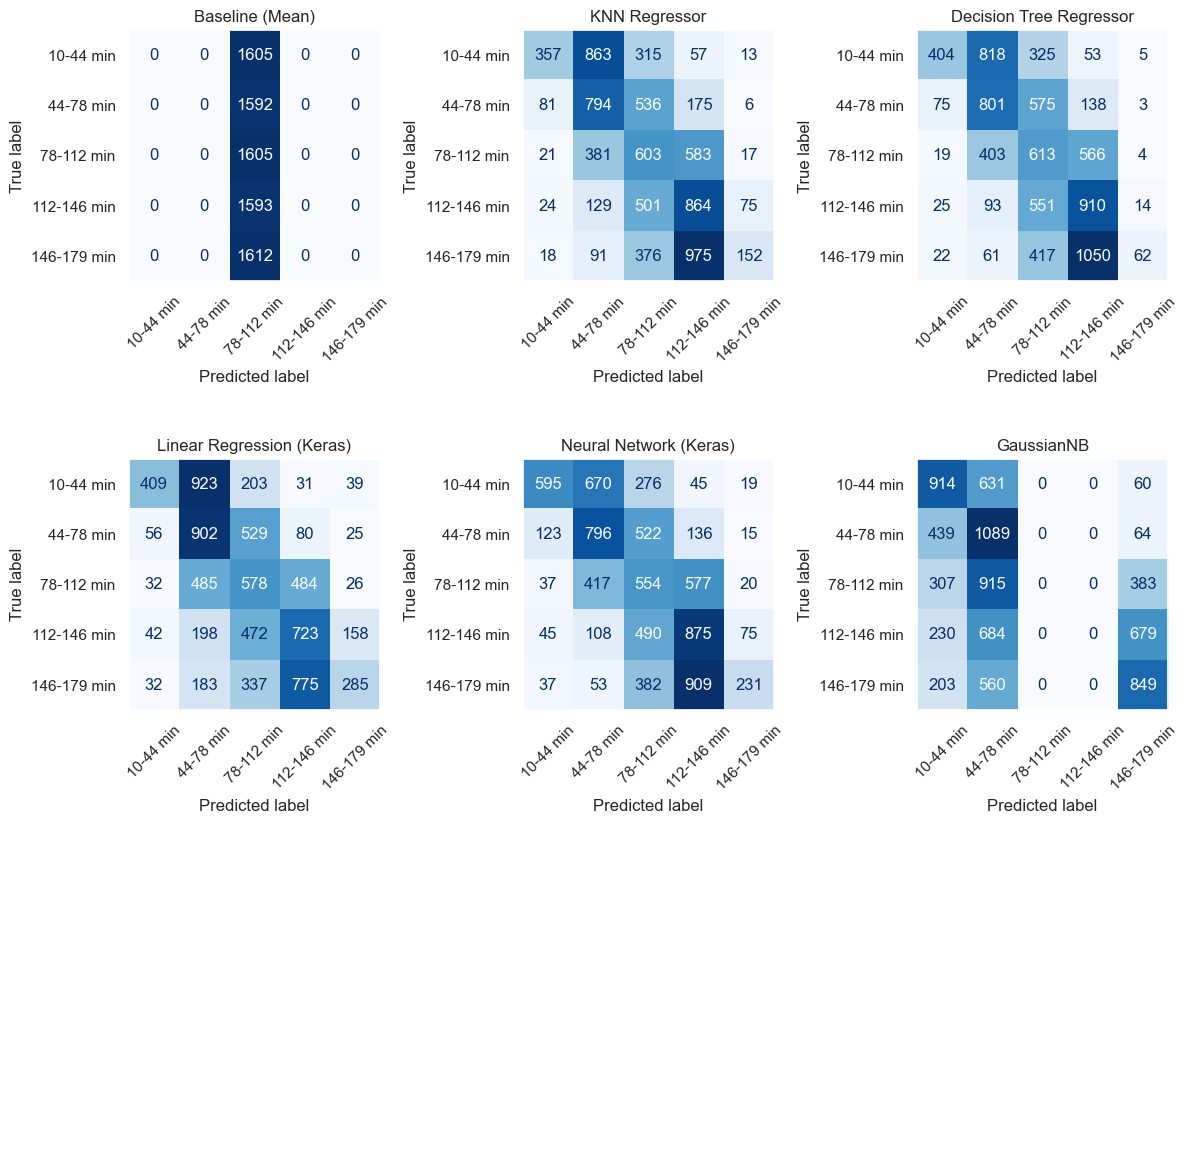

In [117]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_test_bins = kbd.transform(y_test.to_numpy().reshape(-1, 1)).astype(int).ravel()
bin_labels = [f"{bin_edges[i]:.0f}-{bin_edges[i+1]:.0f} min" for i in range(len(bin_edges) - 1)]


def values_to_bins(values: np.ndarray) -> np.ndarray:
    """Mapeia valores contínuos para os índices de faixa usados pelo discretizador."""
    bins = np.digitize(values, bin_edges[1:-1])
    return np.clip(bins, 0, len(bin_labels) - 1)


pred_bins = {
    "Baseline (Mean)": values_to_bins(baseline.predict(X_test)),
    "KNN Regressor": values_to_bins(knn.predict(X_test)),
    "Decision Tree Regressor": values_to_bins(dt.predict(X_test)),
    "Linear Regression (Keras)": values_to_bins(y_pred_lr),
    "Neural Network (Keras)": values_to_bins(y_pred_mlp),
    "GaussianNB": gnb_clf.predict(X_test),
}

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
axes = axes.flatten()

for ax, (model_name, y_pred_bins) in zip(axes, pred_bins.items()):
    cm = confusion_matrix(y_test_bins, y_pred_bins, labels=range(len(bin_labels)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=bin_labels)
    disp.plot(ax=ax, cmap="Blues", colorbar=False, xticks_rotation=45)
    ax.set_title(model_name)

for ax in axes[len(pred_bins) :]:
    ax.axis("off")

plt.tight_layout()
plt.show()


Análise: todas as matrizes mostram colapso para o centro porque, com as features atuais, o modelo não consegue distinguir os jogadores de sessão curta dos de sessão longa; então ele prefere errar pouco em muitos do que acertar muito poucos. Modelo aprendeu que chutar na metade a melhor opção
